# **Binary Classification**

## **1. Make classification data and get it ready**

In [1]:
from sklearn.datasets import make_circles

X, y = make_circles(n_samples=1000,
                    noise=0.03,
                    random_state=42)

print(len(X), len(y))
print(X.shape, y.shape)

print(X[:5],"\n")
print(y[:5])

1000 1000
(1000, 2) (1000,)
[[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]] 

[1 1 1 1 0]


In [2]:
import pandas as pd

df_circle = pd.DataFrame({"X1": X[:, 0],
                          "X2": X[:, 1],
                          "label": y})

display(df_circle.head())
print(df_circle.shape)

# # Check different labels distribution
# df_circle["label"].value_counts()
df_circle.label.value_counts()

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0


(1000, 3)


label
1    500
0    500
Name: count, dtype: int64

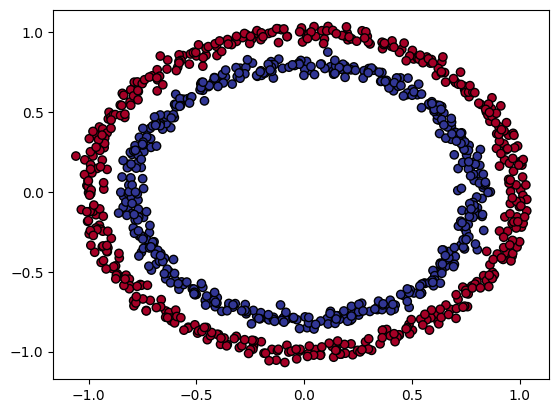

In [3]:
import matplotlib.pyplot as plt

# plt.scatter(x=X[:, 0],
#             y=X[:, 1],
#             c=y,
#             cmap=plt.cm.RdYlBu);

plt.scatter(x=df_circle['X1'],
            y=df_circle["X2"],
            c=y,
            cmap=plt.cm.RdYlBu, edgecolors="black")
plt.show()

In [4]:
import torch
torch.__version__

'2.2.1+cu121'

In [5]:
# Checking the `type` and `data type`
print(type(X), X.dtype)

<class 'numpy.ndarray'> float64


In [6]:
# Turning the data from numpy array to tensors
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

print(X.dtype, y.dtype)
print(X[:5], y[:5])

torch.float32 torch.float32
tensor([[ 0.7542,  0.2315],
        [-0.7562,  0.1533],
        [-0.8154,  0.1733],
        [-0.3937,  0.6929],
        [ 0.4422, -0.8967]]) tensor([1., 1., 1., 1., 0.])


- `torch.from_numpy(X)`: Converts NumPy array to PyTorch tensor **with the same data typ**e as the NumPy array.

- `torch.from_numpy(X).type(torch.float)`: Converts NumPy array to PyTorch tensor, fo**rcing it to be a 32-bit float (float32)** regardless of the original data type.

In [7]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    random_state=42)

print(len(X_train), len(X_test), len(y_train), len(y_test))
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
print(X_train[:5], y_train[:5])

800 200 800 200
torch.Size([800, 2]) torch.Size([200, 2]) torch.Size([800]) torch.Size([200])
tensor([[ 0.6579, -0.4651],
        [ 0.6319, -0.7347],
        [-1.0086, -0.1240],
        [-0.9666, -0.2256],
        [-0.1666,  0.7994]]) tensor([1., 0., 0., 0., 1.])


This code keeps `shuffle=True` (default) for randomization and sets `stratify=None` since the dataset is a balanced dataset.

## **2. Building a model**

1.   Setup **device agonistic code**.
2. Construct a **model** by subclassing `nnModule`.
3. Define a **loss function** and **optimizer**.
4. Create a **training** and **test loop**.

In [8]:
import torch
from torch import nn

# Device agonistic code
device = "cuda" if torch.cuda.is_available() else "cpu"

print(device)

cpu


Now we've setup device agnostic code, let's create a model that:

1. Subclasses `nn.Module` (almost all models in **PyTorch** subclass `nn.Module`).
2. Create two `nn.Linear()` layers that are capable of handling the shapes of our data.
3. Defines a `forward()` method that outlines the forward pass (or forward computation) of the model.
4. Instatiate an instance of our model class and then send it to the target `device`.

In [9]:
# 1. Construct a model that subclasses nn.Module
class CircleModelV0(nn.Module):
  def __init__(self):
    super().__init__()
    # 2. Create 2 nn.Linear layers capable of handling the shapes of our data
    self.layer_1 = nn.Linear(in_features=2, out_features=5) # takes in 2 features and upscales to 5 features
    self.layer_2 = nn.Linear(in_features=5, out_features=1) # takes in 5 features from previous layer and outputs a single feature (same shape as y)

  # 3. Define a forward() method that outlines the forward pass
  def forward(self, x):
    return self.layer_2(self.layer_1(x)) # x -> layer_1 ->  layer_2 -> output

# 4. Instantiate an instance of our model class and send it to the target device
model_0 = CircleModelV0().to(device)
model_0

CircleModelV0(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

In [10]:
# checking the device
device

'cpu'

In [11]:
next(model_0.parameters())

Parameter containing:
tensor([[-0.6639, -0.2159],
        [-0.6852,  0.5426],
        [-0.3410,  0.2300],
        [-0.3275, -0.2688],
        [ 0.6635,  0.3761]], requires_grad=True)

The code `next(model_0.parameters())` returns the first parameter tensor (like weights or biases) of a PyTorch model named `model_0`. It’s often used for debugging or understanding the model structure.

In [12]:
# Let's replicate the model above using nn.Sequential()
model_0 = nn.Sequential(
    nn.Linear(in_features=2, out_features=5),
    nn.Linear(in_features=5, out_features=1)
)

# Move all the parameters and buffers of the model to the device (CPU or GPU)
model_0.to(device)

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

So `nn.Sequential()` implement most of the code for us behind the scene.

```python
# 1. Construct a model that subclasses nn.Module
class CircleModelV0(nn.Module):
  def __init__(self):
    .
    .
    .
model_0
```


`.state_dict()` **Method**:
- Returns a dictionary holding the current state of the model. This state includes the learned parameters (**weights** and **biases**) of each layer in the model.
- It’s often used for saving and loading models because it allows you to easily save all the learned parameters in a file and then load them back into a model.

In [13]:
model_0.state_dict()

OrderedDict([('0.weight',
              tensor([[-0.5536,  0.3478],
                      [-0.0382,  0.5884],
                      [-0.6475, -0.5478],
                      [ 0.6064,  0.2708],
                      [-0.1640,  0.4544]])),
             ('0.bias', tensor([-0.0250,  0.5494, -0.5236,  0.6884,  0.3562])),
             ('1.weight',
              tensor([[-0.1266, -0.1624, -0.4180,  0.1062, -0.0905]])),
             ('1.bias', tensor([-0.2936]))])

Now we've got a model, let's see what happens when we pass some data through it.

In [14]:
# Make predictions
with torch.inference_mode():
    untrained_preds = model_0(X_test.to(device))
    print(f"Length of predictions: {len(untrained_preds)}, Shape: {untrained_preds.shape}")
    print(f"Length of test samples: {len(X_test)}, Shape: {X_test.shape}")
    print(f"\nFirst 10 predictions:\n{torch.round(untrained_preds[:10])}")
    print(f"\nFirst 10 labels:\n{y_test[:10]}")

Length of predictions: 200, Shape: torch.Size([200, 1])
Length of test samples: 200, Shape: torch.Size([200, 2])

First 10 predictions:
tensor([[-0.],
        [-0.],
        [-0.],
        [-0.],
        [-0.],
        [0.],
        [0.],
        [0.],
        [-0.],
        [-0.]])

First 10 labels:
tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])


In [15]:
X_test[:10], y_test[:10]

(tensor([[-0.3752,  0.6827],
         [ 0.0154,  0.9600],
         [-0.7028, -0.3147],
         [-0.2853,  0.9664],
         [ 0.4024, -0.7438],
         [ 0.6323, -0.5711],
         [ 0.8561,  0.5499],
         [ 1.0034,  0.1903],
         [-0.7489, -0.2951],
         [ 0.0538,  0.9739]]),
 tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.]))

## **Setup loss function, optimizer and accuracy**

**Logits:**

- Raw output/scores that a classification model predicts before they are turned into probabilities.
- `logits` refer to the raw, non-normalized output of a classification model. These outputs, which are real numbers, are passed through an activation function like the softmax function to transform them into probabilities. The probabilities sum up to 1 and can be used to predict the class of an input.

- Imagine them as a model's unfiltered opinion on how likely something belongs to a certain category.


In [16]:
# Create a loss function
# loss_fn = nn.BCELoss() # BCELoss = no sigmoid built-in
loss_fn = nn.BCEWithLogitsLoss() # BCEWithLogitsLoss = sigmoid built-in

# Create an optimizer
optimizer = torch.optim.SGD(params=model_0.parameters(),
                            lr=0.1)

# Calculate accuracy - out of 100 examples, what percentage does our model get right?
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct/len(y_pred))*100
    return acc

- `torch.eq(y_true, y_pred)`: This compares two PyTorch tensors `y_true` and `y_pred` element-wise and returns a new tensor with Boolean values (True or False). True indicates the elements in the corresponding positions are equal.

- `.sum()`: This operation sums up all the elements in the tensor. In this context, it adds up all the True values (treated as 1) from the previous operation, effectively counting the number of correct predictions.

- `.item()`: This converts the one-element PyTorch tensor to a standard Python number.

In [17]:
a =[1, 2, 3, 4, 7]
b =[1, 3, 3, 4, 9]

a = torch.tensor(a)
b = torch.tensor(b)
print(torch.eq(a, b))
print(torch.eq(a, b).sum())
print(torch.eq(a, b).sum().item())

tensor([ True, False,  True,  True, False])
tensor(3)
3


## **3. Train model**

To train our model, we're going to need to build a training loop with the following steps:

<details>
    <summary>PyTorch training loop steps</summary>
    <ol>
        <li><b>Forward pass</b> - The model goes through all of the training data once, performing its
            <code>forward()</code> function
            calculations (<code>model(x_train)</code>).
        </li>
        <li><b>Calculate the loss</b> - The model's outputs (predictions) are compared to the ground truth and evaluated
            to see how
            wrong they are (<code>loss = loss_fn(y_pred, y_train</code>).</li>
        <li><b>Zero gradients</b> - The optimizers gradients are set to zero (they are accumulated by default) so they
            can be
            recalculated for the specific training step (<code>optimizer.zero_grad()</code>).</li>
        <li><b>Perform backpropagation on the loss</b> - Computes the gradient of the loss with respect for every model
            parameter to
            be updated (each parameter
            with <code>requires_grad=True</code>). This is known as <b>backpropagation</b>, hence "backwards"
            (<code>loss.backward()</code>).</li>
        <li><b>Step the optimizer (gradient descent)</b> - Update the parameters with <code>requires_grad=True</code>
            with respect to the loss
            gradients in order to improve them (<code>optimizer.step()</code>).</li>
    </ol>
</details>

- **Model Output ~ (Raw logits)** to $\rightarrow$ **prediction `probabilities`(Using Sigmoid/Softmax) to** $\rightarrow$ **prediction `labels`(by `torch.round()`/`argmax()`)**

- `y_logits` $\rightarrow$ `y_pred_probs` $\rightarrow$ `y_pred_labels`



In [18]:
# View the first 5 outputs of the forward pass on the test data
model_0.eval()
with torch.inference_mode():
  y_logits = model_0(X_test.to(device))[:5]
print("y_logits:", y_logits)  # Since our model hasn't been trained, these outputs are basically random

# Use the sigmoid activation function on our model logits to turn them into prediction probabilities
y_pred_probs = torch.sigmoid(y_logits)
print("y_pred_probs: ", y_pred_probs)

# Find the predicted labels
y_pred_labels = torch.round(y_pred_probs)
print("y_pred_labels: ", y_pred_labels, y_pred_labels.shape)

# Check for equality
print(torch.eq(y_pred_probs.squeeze(), y_pred_labels.squeeze()))

# Get rid of extra dimension
print(y_pred_labels.squeeze(), y_pred_labels.squeeze().shape)

# our model's predictions are in the same form as our truth labels (y_test).
print(y_test[:5])

y_logits: tensor([[-0.2272],
        [-0.0394],
        [-0.4436],
        [-0.1670],
        [-0.0056]])
y_pred_probs:  tensor([[0.4434],
        [0.4902],
        [0.3909],
        [0.4583],
        [0.4986]])
y_pred_labels:  tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.]]) torch.Size([5, 1])
tensor([False, False, False, False, False])
tensor([0., 0., 0., 0., 0.]) torch.Size([5])
tensor([1., 0., 1., 0., 1.])


**Without training**

In [19]:
import torch
import torch.nn as nn

    # 1. Construct a model that subclasses nn.Module
class CircleModelV0(nn.Module):
    def __init__(self):
        super().__init__()
    # 2. Create 2 nn.Linear layers capable of handling the shapes of our data
        self.layer_1 = nn.Linear(in_features=2, out_features=5) # takes in 2 features and upscales to 5 features
        self.layer_2 = nn.Linear(in_features=5, out_features=1) # takes in 5 features from previous layer and outputs a single feature (same shape as y)

    # 3. Define a forward() method that outlines the forward pass
    def forward(self, x):
        return self.layer_2(self.layer_1(x)) # x -> layer_1 ->  layer_2 -> output

    # Calculate accuracy - out of 100 examples, what percentage does our model get right?
    @staticmethod
    def accuracy_fn(y_true, y_pred):
        # Assuming y_true and y_pred are tensors
        correct = torch.eq(y_true, y_pred).sum().item()
        acc = (correct / len(y_pred)) * 100
        return acc

# 4. Instantiate an instance of our model class and send it to the target device
model_0 = CircleModelV0().to(device)

# Create a loss function
loss_fn = nn.BCEWithLogitsLoss()  # BCEWithLogitsLoss includes sigmoid internally

# Create an optimizer
optimizer = torch.optim.SGD(params=model_0.parameters(), lr=0.1)


# Evaluate the model and calculate accuracy
model_0.eval()  # Set the model to evaluation mode
with torch.no_grad():  # Turn off gradient computation during inference
    y_logits = model_0(X_test.to(device))      # Assuming X_test is your test data
    y_pred_probs = torch.sigmoid(y_logits)     # Apply sigmoid to get probabilities
    y_pred_labels = torch.round(y_pred_probs)  # Round probabilities to 0 or 1


# Calculate accuracy using your accuracy_fn
accuracy = CircleModelV0.accuracy_fn(y_test, y_pred_labels.squeeze())
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 49.00


- `torch.no_grad()` : is used temporarily suspends gradient calculation with the autograd engine. During training, we calculate gradients to update model weights based on the loss function. However, in testing, we only need the model's output, not the gradients. Disabling gradient calculation with torch.`no_grad()` frees up memory and speeds up inference because the autograd engine doesn't need to track gradients for backpropagation

- `torch.inference_mode()` : is designed for inference-specific behaviors, allowing you to disable autograd while still permitting certain inference-related operations like batch normalization.

For most cases of inference, `torch.no_grad()` is the standard choice to disable gradient computation. Use `torch.inference_mode()` when you need fine-grained control over inference-specific behaviors beyond just gradient computation.

For our prediction probability values, we need to perform a range-style rounding on them:

- `y_pred_probs` >= 0.5, `y=1` (class 1)
- `y_pred_probs` < 0.5, `y=0` (class 0)

### **Building a Training and Testing loop**

#### **The Unofficial PyTorch Optimization Loop Song**
```
    For an epoch in a range
    Call model dot train
    Do the forward pass (y_logits, y_pred)
    Calculate the loss
    Optimizer zero grad
    Lossssss backward
    Optimizer step step step

    Test time!
    Call model dot eval
    With torch inference mode
    Do the forward pass (y_logits, y_pred)
    Calculate the loss

    Print out what's happenin'
```

### Using `class` based approch.

- Training for **100 epochs** without Non-Linear Function

Epoch: 0 | loss: 0.69989 | Accuracy: 48.38 | Test loss: 0.70629 | Test acc: 49.00
Epoch: 10 | loss: 0.69654 | Accuracy: 49.88 | Test loss: 0.70242 | Test acc: 49.00
Epoch: 20 | loss: 0.69515 | Accuracy: 50.38 | Test loss: 0.70045 | Test acc: 48.50
Epoch: 30 | loss: 0.69440 | Accuracy: 50.62 | Test loss: 0.69918 | Test acc: 48.50
Epoch: 40 | loss: 0.69394 | Accuracy: 51.00 | Test loss: 0.69827 | Test acc: 47.50
Epoch: 50 | loss: 0.69363 | Accuracy: 50.88 | Test loss: 0.69758 | Test acc: 47.50
Epoch: 60 | loss: 0.69343 | Accuracy: 51.12 | Test loss: 0.69705 | Test acc: 47.00
Epoch: 70 | loss: 0.69329 | Accuracy: 51.00 | Test loss: 0.69664 | Test acc: 47.50
Epoch: 80 | loss: 0.69320 | Accuracy: 51.25 | Test loss: 0.69630 | Test acc: 47.50
Epoch: 90 | loss: 0.69313 | Accuracy: 51.12 | Test loss: 0.69604 | Test acc: 47.00




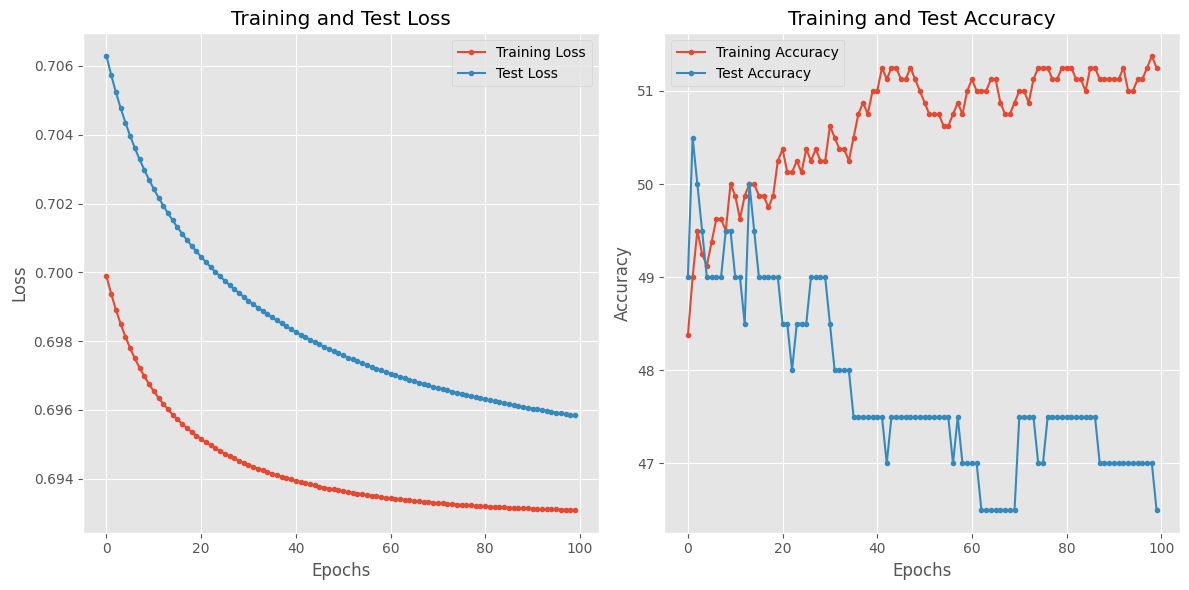

In [20]:
import torch
from torch import nn

torch.manual_seed(42)

# Device Agnostic Code
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # 1. Construct a model that subclasses nn.Module
class CircleModelV0(nn.Module):
    def __init__(self):
        super().__init__()
    # 2. Create 2 nn.Linear layers capable of handling the shapes of our data
        self.layer_1 = nn.Linear(in_features=2, out_features=10)  # takes in 2 features and upscales to 10 features
        self.layer_2 = nn.Linear(in_features=10, out_features=1)  # takes in 10 features from previous layer and outputs a single feature (same shape as y)


    # 3. Define a forward() method that outlines the forward pass
    def forward(self, x):
        # return self.layer_2(self.layer_1(x)) # x -> layer_1 ->  layer_2 -> output
        return self.layer_2(self.layer_1(x))

# 4. Instantiate an instance of our model class and send it to the target device
model_0 = CircleModelV0().to(device)

# Create a loss function
loss_fn = nn.BCEWithLogitsLoss()  # BCEWithLogitsLoss includes sigmoid internally

# Create an optimizer
optimizer = torch.optim.SGD(model_0.parameters(), lr=0.1)

# Create an accuracy function
def accuracy_fn(y_true, y_pred):
    num_correct = torch.eq(y_true, y_pred).sum().item()
    accuracy = (num_correct / len(y_pred)) * 100
    return accuracy

# Set the number of Epochs
epochs = 100

# Define lists to store metrics for plotting
train_losses, train_accuracies = [], []
test_losses, test_accuracies = [], []

# Put the data to the target device
X_train, X_test = X_train.to(device), X_test.to(device)
y_train, y_test = y_train.to(device), y_test.to(device)

# Building training and evaluation loop
for epoch in range(epochs):
    ### Training
    model_0.train()

    # 1. Forward pass [model output RAW logits]
    y_logits = model_0(X_train).squeeze()         # squeeze to remove extra `1` dimensions
    y_pred = torch.round(torch.sigmoid(y_logits)) # turn logits -> pred probs -> pred lables

    # 2. Calculate [loss/accuracy]
    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_true=y_train, y_pred=y_pred)

    # 3. Optimizer zero grad (Clear gradients before computing new gradients)
    optimizer.zero_grad()

    # 4. Loss backward (backpropagation)
    loss.backward()

    # 5. Optimizer step (gradient descent)
    optimizer.step()

    # Appending train loss and accuracy to the list
    train_losses.append(loss.item())
    train_accuracies.append(acc)

    ### Testing
    model_0.eval()
    with torch.inference_mode():
        # 1. Forward pass
        test_logits = model_0(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))

        # 2. Calculate test loss/accuracy
        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(y_true=y_test, y_pred=test_pred)

        # Appending test loss and test accuracy to the list
        test_losses.append(test_loss.item())
        test_accuracies.append(test_acc)

    # Training progress report/model evaluation summary
    # Print out what's happening after 10 epochs
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | loss: {loss:.5f} | Accuracy: {acc:.2f} | Test loss: {test_loss:.5f} | Test acc: {test_acc:.2f}")

print("\n")

# Plotting training and testing metrics
plt.figure(figsize=(12, 6))
plt.style.use("ggplot")

plt.subplot(1, 2, 1)
plt.plot(range(epochs), train_losses, label="Training Loss", marker='.')
plt.plot(range(epochs), test_losses, label="Test Loss", marker='.')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Test Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(epochs), train_accuracies, label="Training Accuracy", marker=".")
plt.plot(range(epochs), test_accuracies, label="Test Accuracy", marker=".")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training and Test Accuracy")
plt.legend()

plt.tight_layout()
plt.show()

**Downloading helper_functions**

In [21]:
import requests
from pathlib import Path

# Download helper functions from Learn PyTorch repo (if it's not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mohd-faizy/PyTorch-Essentials/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

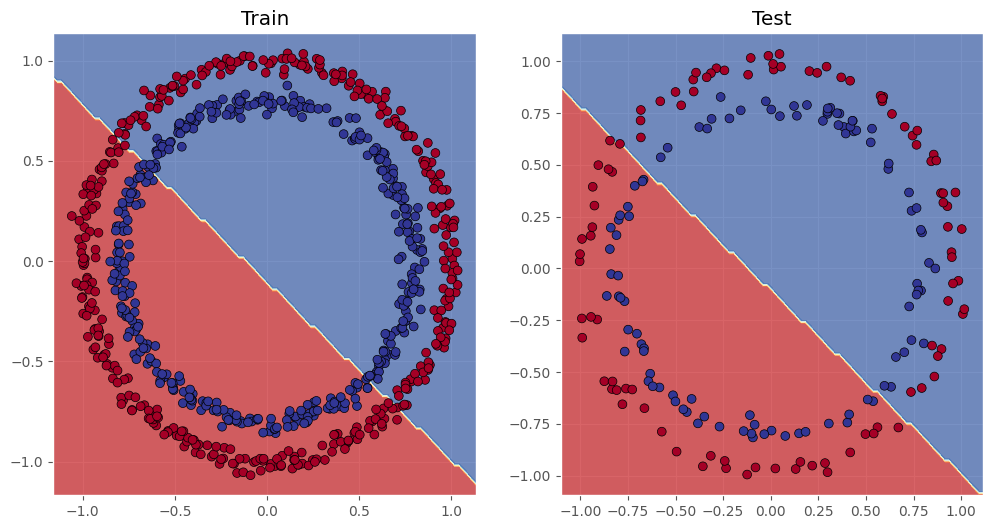

In [22]:
from helper_functions import plot_predictions, plot_decision_boundary

# plotting the decision boundary of the model
plt.figure(figsize=(12, 6))
plt.style.use("ggplot")

plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)

plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)

- Training for **1000 epochs** with ReLU non-linear activation function.

Epoch: 0 | Loss: 0.69753 | Accuracy: 50.00 | Test Loss: 0.69784 | Test Accuracy: 50.00
Epoch: 100 | Loss: 0.68987 | Accuracy: 56.25 | Test Loss: 0.69139 | Test Accuracy: 51.50
Epoch: 200 | Loss: 0.68663 | Accuracy: 52.88 | Test Loss: 0.68875 | Test Accuracy: 52.00
Epoch: 300 | Loss: 0.68264 | Accuracy: 53.62 | Test Loss: 0.68576 | Test Accuracy: 52.50
Epoch: 400 | Loss: 0.67735 | Accuracy: 54.00 | Test Loss: 0.68189 | Test Accuracy: 53.50
Epoch: 500 | Loss: 0.67006 | Accuracy: 56.00 | Test Loss: 0.67640 | Test Accuracy: 55.50
Epoch: 600 | Loss: 0.65938 | Accuracy: 62.38 | Test Loss: 0.66777 | Test Accuracy: 58.00
Epoch: 700 | Loss: 0.64168 | Accuracy: 75.50 | Test Loss: 0.65325 | Test Accuracy: 68.50
Epoch: 800 | Loss: 0.61284 | Accuracy: 87.38 | Test Loss: 0.62886 | Test Accuracy: 85.00
Epoch: 900 | Loss: 0.56398 | Accuracy: 97.25 | Test Loss: 0.58723 | Test Accuracy: 93.00




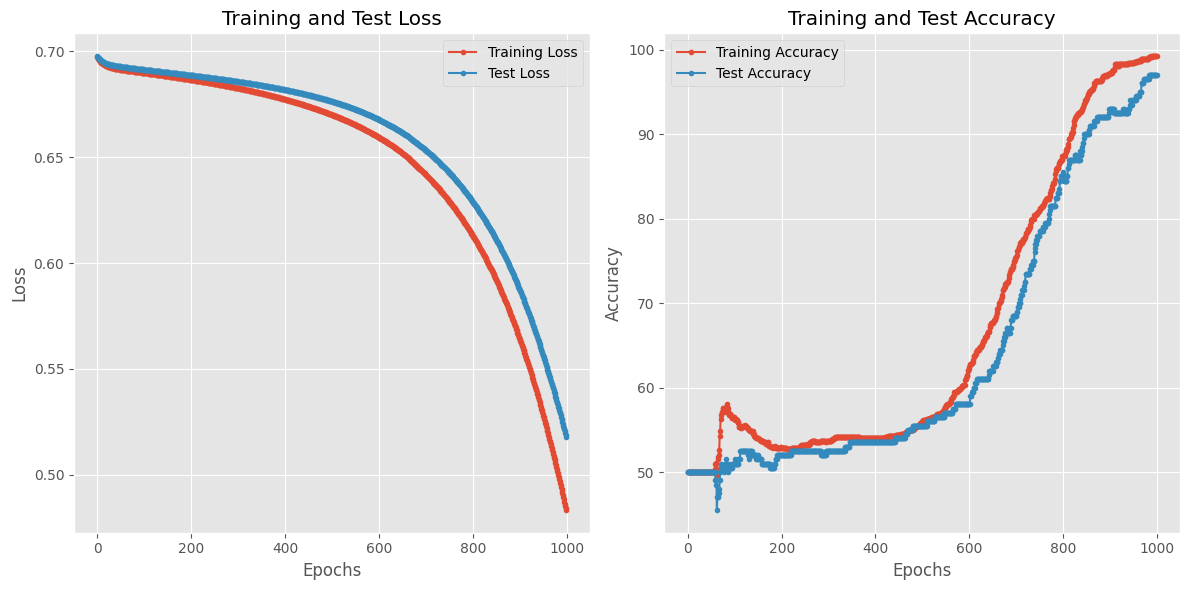

In [23]:
import torch
from torch import nn
import matplotlib.pyplot as plt

# Assuming you have defined X_train, X_test, y_train, y_test, and device
# Define device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

torch.manual_seed(42)

# Define the model
class CircleModelV1(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=16)
        self.layer_2 = nn.Linear(in_features=16, out_features=16)
        self.layer_3 = nn.Linear(in_features=16, out_features=1)
        self.relu = nn.ReLU()

    def forward(self, x):
        return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))


# Instantiate the model and send it to the target device
model_1 = CircleModelV1().to(device)

# Create a loss function, optimizer, and accuracy function
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model_1.parameters(), lr=0.1)

def accuracy_fn(y_true, y_pred):
    num_correct = torch.eq(y_true, y_pred).sum().item()
    accuracy = (num_correct / len(y_pred)) * 100
    return accuracy

# Set the number of Epochs
epochs = 1000

# Define lists to store metrics for plotting
train_losses, train_accuracies = [], []
test_losses, test_accuracies = [], []

# Put the data to the target device
X_train, X_test = X_train.to(device), X_test.to(device)
y_train, y_test = y_train.to(device), y_test.to(device)

# Building training and evaluation loop
for epoch in range(epochs):
    ### Training
    model_0.train()
    y_logits = model_1(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))
    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_true=y_train, y_pred=y_pred)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    train_losses.append(loss.item())
    train_accuracies.append(acc)

    ### Testing
    model_0.eval()
    with torch.no_grad():
        test_logits = model_1(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))
        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(y_true=y_test, y_pred=test_pred)

    test_losses.append(test_loss.item())
    test_accuracies.append(test_acc)

    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss.item():.5f} | Accuracy: {acc:.2f} | Test Loss: {test_loss.item():.5f} | Test Accuracy: {test_acc:.2f}")

print("\n")

# Plotting training and testing metrics
plt.figure(figsize=(12, 6))
plt.style.use("ggplot")

plt.subplot(1, 2, 1)
plt.plot(range(epochs), train_losses, label="Training Loss", marker='.')
plt.plot(range(epochs), test_losses, label="Test Loss", marker='.')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Test Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(epochs), train_accuracies, label="Training Accuracy", marker=".")
plt.plot(range(epochs), test_accuracies, label="Test Accuracy", marker=".")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training and Test Accuracy")
plt.legend()

plt.tight_layout()
plt.show()

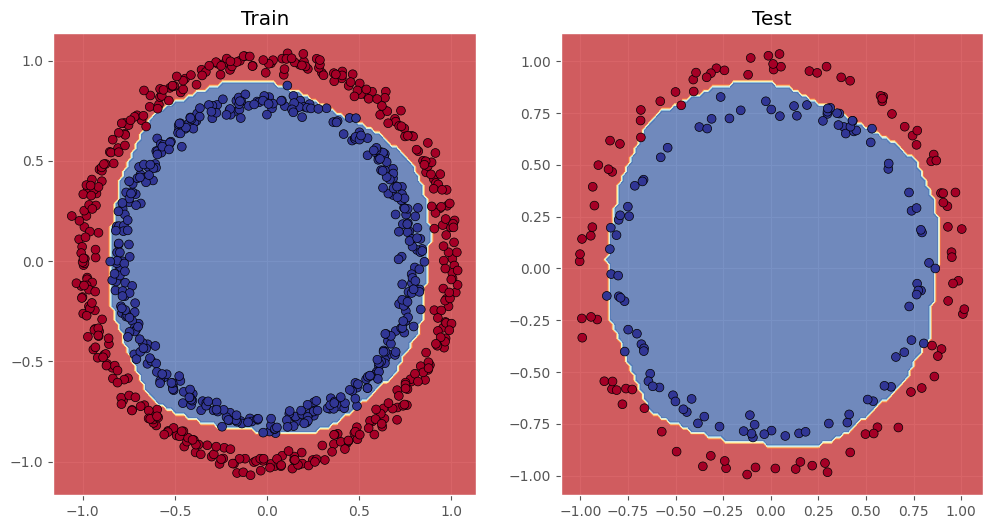

In [24]:
from helper_functions import plot_predictions, plot_decision_boundary

# plotting the decision boundary of the model
plt.figure(figsize=(12, 6))
plt.style.use("ggplot")

plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train)

plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_1, X_test, y_test)

### Using `nn.sequential()`

Epoch: 0 | Loss: 0.69753 | Accuracy: 50.00 | Test Loss: 0.69784 | Test Accuracy: 50.00
Epoch: 100 | Loss: 0.68987 | Accuracy: 56.25 | Test Loss: 0.69139 | Test Accuracy: 51.50
Epoch: 200 | Loss: 0.68663 | Accuracy: 52.88 | Test Loss: 0.68875 | Test Accuracy: 52.00
Epoch: 300 | Loss: 0.68264 | Accuracy: 53.62 | Test Loss: 0.68576 | Test Accuracy: 52.50
Epoch: 400 | Loss: 0.67735 | Accuracy: 54.00 | Test Loss: 0.68189 | Test Accuracy: 53.50
Epoch: 500 | Loss: 0.67006 | Accuracy: 56.00 | Test Loss: 0.67640 | Test Accuracy: 55.50
Epoch: 600 | Loss: 0.65938 | Accuracy: 62.38 | Test Loss: 0.66777 | Test Accuracy: 58.00
Epoch: 700 | Loss: 0.64168 | Accuracy: 75.50 | Test Loss: 0.65325 | Test Accuracy: 68.50
Epoch: 800 | Loss: 0.61284 | Accuracy: 87.38 | Test Loss: 0.62886 | Test Accuracy: 85.00
Epoch: 900 | Loss: 0.56398 | Accuracy: 97.25 | Test Loss: 0.58723 | Test Accuracy: 93.00




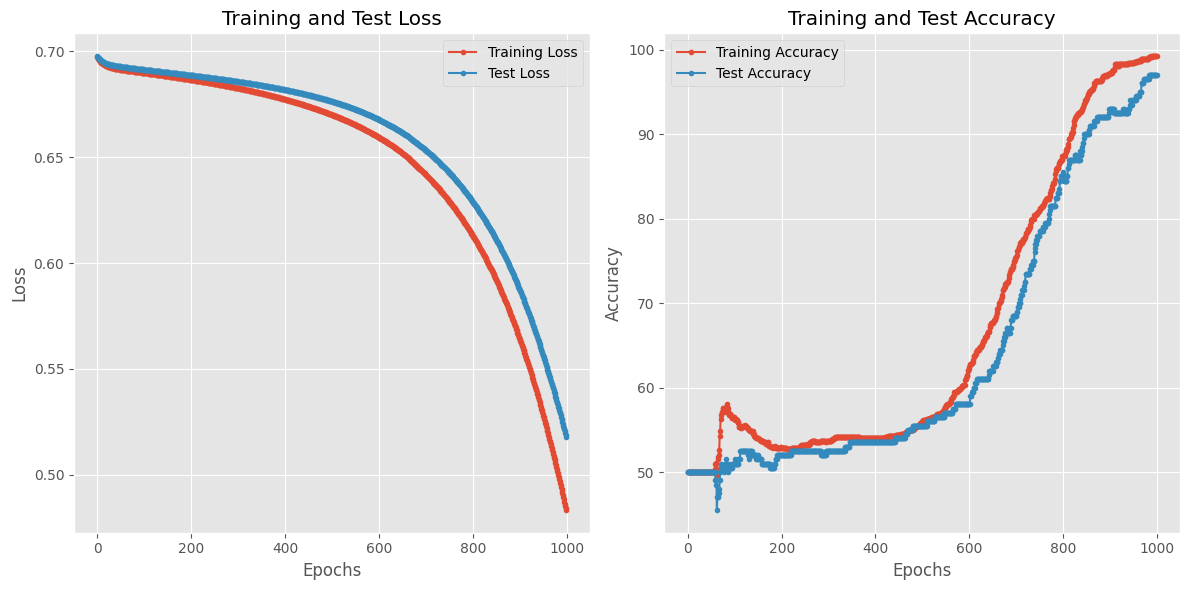

In [25]:
import torch
from torch import nn
import matplotlib.pyplot as plt

# Assuming you have defined X_train, X_test, y_train, y_test, and device
# Define device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

torch.manual_seed(42)

# Define the model
model_2 = nn.Sequential(
    nn.Linear(in_features=2, out_features=16),
    nn.ReLU(),
    nn.Linear(in_features=16, out_features=16),
    nn.ReLU(),
    nn.Linear(in_features=16, out_features=1)
).to(device)  # Move model to device

# Create a loss function, optimizer, and accuracy function
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model_2.parameters(), lr=0.1)  # Corrected model name

def accuracy_fn(y_true, y_pred):
    num_correct = torch.eq(y_true, y_pred).sum().item()
    accuracy = (num_correct / len(y_pred)) * 100
    return accuracy

# Set the number of Epochs
epochs = 1000

# Define lists to store metrics for plotting
train_losses, train_accuracies = [], []
test_losses, test_accuracies = [], []

# Assuming data is already on the device
# Building training and evaluation loop
for epoch in range(epochs):
    ### Training
    model_2.train()  # Corrected model name
    y_logits = model_2(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))
    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_true=y_train, y_pred=y_pred)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    train_losses.append(loss.item())
    train_accuracies.append(acc)

    ### Testing
    model_2.eval()  # Corrected model name
    with torch.no_grad():
        test_logits = model_2(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))
        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(y_true=y_test, y_pred=test_pred)

    test_losses.append(test_loss.item())
    test_accuracies.append(test_acc)

    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss.item():.5f} | Accuracy: {acc:.2f} | Test Loss: {test_loss.item():.5f} | Test Accuracy: {test_acc:.2f}")

print("\n")

# Plotting training and testing metrics
plt.figure(figsize=(12, 6))
plt.style.use("ggplot")

plt.subplot(1, 2, 1)
plt.plot(range(epochs), train_losses, label="Training Loss", marker='.')
plt.plot(range(epochs), test_losses, label="Test Loss", marker='.')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Test Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(epochs), train_accuracies, label="Training Accuracy", marker=".")
plt.plot(range(epochs), test_accuracies, label="Test Accuracy", marker=".")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training and Test Accuracy")
plt.legend()

plt.tight_layout()
plt.show()

**NOTE:** Using a class-based approach to define your model offers more flexibility, customization options, and better organization compared to `nn`.Sequential. It's especially beneficial for **complex models**, **custom functionality**, **parameter access**, **stateful operations**, **debugging**, **logging**, and **code organization**.






